In [11]:
import pandas as pd
from IPython.display import clear_output
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image as PILImage

# Paths configuration
PATH_ROOT = Path("/home/tom-ratsakatika/VSCode/camera-traps/data/")
original_labelled_data_path = PATH_ROOT / 'structured_data_with_deepfaune.xlsx'
new_labelled_data_path = PATH_ROOT / 'structured_data_with_deepfaune_ground_truth.xlsx'

# Read data
df = pd.read_excel(original_labelled_data_path, sheet_name='structured_data')

df

,Sort,Session,Category,GMU,TrapSite,Longitude,Latitude,Altitude,StartDate,EndDate,...,score,count,humanpresence,FCC_Master_Class,DF(base)_Master_Class,DF(sequence)_Master_Class,FCC_DF(base)_Match,FCC_DF(sequence)_Match,DF(base)_DF(sequence)_Match,Ground_Truth
0,9,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,0.97,1,0,Fox,Fox,Fox,True,True,True,Fox
1,9,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,0.97,1,0,Fox,Fox,Fox,True,True,True,Fox
2,10,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,1.00,0,0,Unknown,Empty**,Empty**,False,False,True,Unknown
3,11,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,0.97,0,0,Fox,Empty**,Fox,False,True,False,Fox
4,11,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,0.97,1,0,Fox,Fox,Fox,True,True,True,Fox
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19592,18852,5,Systematic monitoring of feeding points,20StoenestiAG,25_ColtulSoimului,25.250000,45.240000,1112,2021-03-22,2021-05-04,...,0.99,2,0,Bear,Bear,Bear,True,True,True,Bear
19593,18852,5,Systematic monitoring of feeding points,20StoenestiAG,25_ColtulSoimului,25.250000,45.240000,1112,2021-03-22,2021-05-04,...,0.99,3,1,Bear,Bear,Bear,True,True,True,Bear
19594,18852,5,Systematic monitoring of feeding points,20StoenestiAG,25_ColtulSoimului,25.250000,45.240000,1112,2021-03-22,2021-05-04,...,0.99,3,1,Bear,Bear,Bear,True,True,True,Bear
19595,18852,5,Systematic monitoring of feeding points,20StoenestiAG,25_ColtulSoimului,25.250000,45.240000,1112,2021-03-22,2021-05-04,...,0.99,3,1,Bear,Bear,Bear,True,True,True,Bear


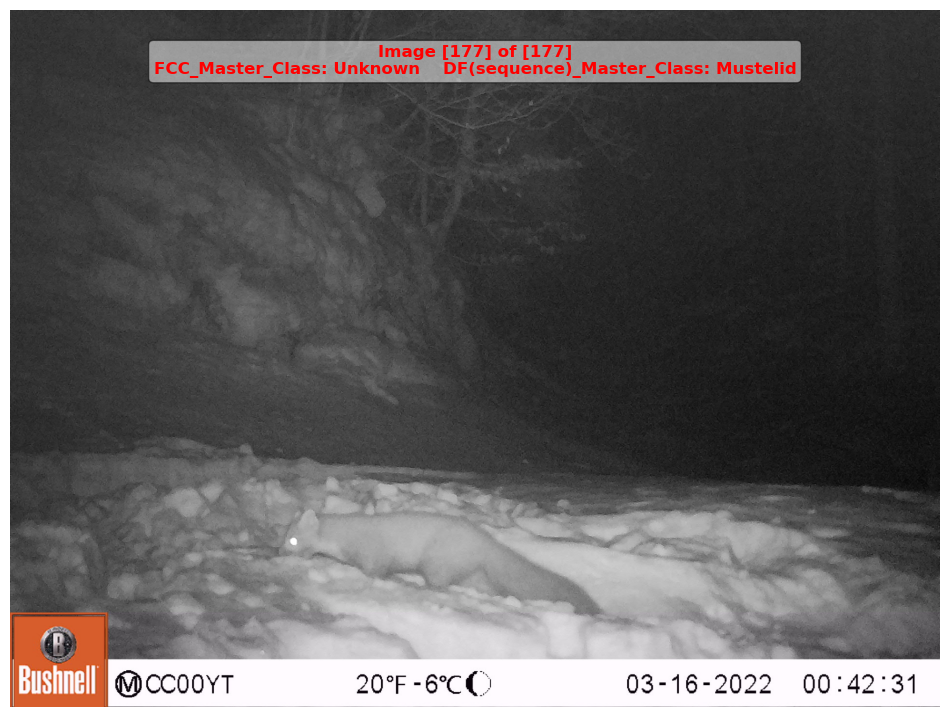

In [15]:
df['Ground_Truth'] = df.apply(
    lambda row: row['FCC_Master_Class'] if (
        row['FCC_DF(sequence)_Match'] == True or
        ('*' in str(row['FCC_Master_Class'])) or
        (row['FCC_Master_Class'] == "Unknown" and row['FCC_DF(sequence)_Match'] not in ["Empty**", "Unknown"] and row['FCC_DF(sequence)_Match'] != False)
    ) else (row['Ground_Truth'] if pd.notna(row['Ground_Truth']) else pd.NA),
    axis=1
)

# Filter to only rows needing manual labeling where Ground_Truth is NaN
df_to_label = df[df['Ground_Truth'].isna()]
total_images = len(df_to_label)

def label_image(image_path, human_label, model_label, current_index, total_images):
    clear_output(wait=False)  # Clear the output to remove the last image

    # Load and display the image
    img = PILImage.open(image_path)
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img)
    
    # Text annotations
    progress_str = f"Image [{current_index}] of [{total_images}]"
    labels_str = f'FCC_Master_Class: {human_label}    DF(sequence)_Master_Class: {model_label}'
    text_str = f"{progress_str}\n{labels_str}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.5, 0.95, text_str, transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='top', bbox=props, color='red', fontweight='bold')
    
    plt.axis('off')  # Turn off axis
    plt.show()       # Show the image with annotations

    # Force valid input
    valid_labels = {'1', '2', '3', '4', ''}
    label = None
    while label not in valid_labels:
        label = input("Enter label [1 (FCC), 2 (DeepFaune), 3 (Exclude), 4 (Neither)]")

    return label

# Iterate through dataframe rows needing manual labeling
current_index = 1
for index, row in df_to_label.iterrows():
    seqnum = row['seqnum']
    seqcount = row['seqcount']
    image_path = row['Full File Name']
    human_label = row['FCC_Master_Class']
    model_label = row['DF(sequence)_Master_Class']
    label = label_image(image_path, human_label, model_label, current_index, total_images)
    if label == "":
        break
    ground_truth = {
        '1': human_label,
        '2': model_label,
        '3': 'Exclude',
        '4': 'Neither'
    }[label]
    
    # Assign Ground_Truth to Ground_Truth column
    df.at[index, 'Ground_Truth'] = ground_truth
    current_index += 1

df.to_excel(new_labelled_data_path, index=False)
